# Predicting Flight Delays with Apache Spark

## CLASSIFICATION

The original Scala based tutorial on Zeppelin Notebooks is at https://mapr.com/blog/fast-data-processing-pipeline-predicting-flight-delays-using-apache-apis-pt-1/. I have coverted them to Python and also configured to run the codes on Jupter Notebooks with Pyspark 2.2 and used the Jupyter Notebook to render visualization and added more stuffs.

Classification is a family of supervised machine learning algorithms that identify which category an item belongs to (e.g., whether a transaction is fraud or not fraud), based on labeled examples of known items (e.g., transactions known to be fraud or not). Classification takes a set of data with known labels and pre-determined features and learns how to label new records based on that information. Features are the “if questions” that you ask. The label is the answer to those questions.

**DECISION TREES**

Decision trees create a model that predicts the label (or class) by evaluating a set of rules that follow an IF THEN ELSE…pattern. The If then ELSE feature questions are the nodes, and the answers True or false are the branches in the tree to the child nodes. A decision tree model estimates the minimum number of true/false questions needed, to assess the probability of making a correct decision. Below is an example of a simplified decision tree for flight delays:

+ Q1: If the scheduled departure time < 10:15 AM
    - T:Q2: If the originating airport is in the set {ORD, ATL,SFO}
        - T:Q3: If the day of the week is in {Monday, Sunday}
            - T:Delayed=1
            - F: Delayed=0
        - F: Q3: If the destination airport is in the set {SFO,ORD,EWR}
            - T: Delayed=1
            - F: Delayed=0
    - F :Q2: If the originating airport is not in the set {BOS . MIA}
        - T:Q3: If the day of the week is in the set {Monday , Sunday}
            - T: Delayed=1
            - F: Delayed=0
        - F: Q3: If the destination airport is not in the set {BOS . MIA}
            - T: Delayed=1
            - F: Delayed=0

**How to Configure Jupter Notebook to run Spark 2.2:**
```
1. Create an Anaconda environment 'pyspark'
2. !pip install pyspark (this package will directly communicate with Spark)
3. Install Spark in your machine (from here: https://spark.apache.org/downloads.html). I installed spark-2.2.0-bin-hadoop2.6.tgz
4. In your .bash_profile set the following
    export SPARK_HOME=/Users/anindyas/work/spark-2.2.0-bin-hadoop2.6
    PATH=$SPARK_HOME/bin:$PATH
    export PATH

    export PATH="/Users/anindyas/anaconda/envs/pyspark/bin:$PATH"
    
    There is further better way to set the environment variables for anaconda but for now it is fine.
5. Switch to pyspark anaconda environment and start the jupyter notebook from that environment.
```

## 1. Understanding the Data Set

Our data is from http://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time. We are using flight information for January, February, March, April and May 2017. For each flight, we have the following information.

<p style="text-align: justify;"></p>
<pre><strong>_id:</strong>Unique identifier: composed of carrier code, date, origin, destination, flight number(e.g. AA_2017-02-22_SFO_ORD_150)
<strong>dofW (Integer):</strong> &nbsp;   Day of week (1=Monday 7=Sunday) (e.g. 1)
<strong>carrier (String):</strong>    Carrier code (e.g. AA)
<strong>origin(String):</strong> Origin Airport Code (e.g. JFK)
<strong>dest(String):</strong>&nbsp;   Destination airport code (e.g. LAX)
<strong>crsdephour(Integer):</strong>       Scheduled departure hour (e.g. 9)
<strong>crsdeptime(Double):</strong>      Scheduled departure time (e.g. 900.0)
<strong>depdelay (Double):</strong>   Departure delay in minutes (e.g. 40.0)
<strong>crsarrtime (Double):</strong>  Scheduled arrival time (e.g. 1230.0)
<strong>arrdelay (Double):</strong>  Arrival delay minutes (e.g. 40.0)
<strong>crselapsedtime (Double)	:</strong>  Elapsed time (e.g. 390.0)
<strong>dist (Double):</strong>  Distance (e.g. 2475.0)
</pre>

The data is already cleaned up, limited the number of airports and carriers, and transformed the data into 2 JSON files, one for training and one for testing. The JSON file has the following format:

<pre>
{
    "_id": "AA_2017-01-01_ATL_LGA_1678",
    "dofW": 7,
    "carrier": "AA",
    "origin": "ATL",
    "dest": "LGA",
    "crsdephour": 17,
    "crsdeptime": 1700,
    "depdelay": 0.0,
    "crsarrtime": 1912,
    "arrdelay": 0.0,
    "crselapsedtime": 132.0,
    "dist": 762.0
}
</pre>

In [1]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
from pyspark.sql.functions import udf, col

from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import Bucketizer, StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

from pyspark.mllib.evaluation import MulticlassMetrics

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [4]:
# setting random seed for notebook reproducability
rnd_seed=36
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

## 2. Creating the Spark Session

In [5]:
# The following must be set in your .bashrc file
#SPARK_HOME="/home/ubuntu/spark-2.4.0-bin-hadoop2.7"
#ANACONDA_HOME="/home/ubuntu/anaconda3/envs/pyspark"
#PYSPARK_PYTHON="$ANACONDA_HOME/bin/python"
#PYSPARK_DRIVER_PYTHON="$ANACONDA_HOME/bin/python"
#PYTHONPATH="$ANACONDA_HOME/bin/python"
#export PATH="$ANACONDA_HOME/bin:$SPARK_HOME/bin:$PATH"

In [6]:
os.environ['SPARK_HOME']

'/home/ubuntu/spark-2.4.0-bin-hadoop2.7'

In [7]:
spark = (SparkSession
         .builder
         .master("local[*]")
         .appName("predict-flight-delays")
         .getOrCreate())
spark

In [8]:
spark

In [9]:
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=predict-flight-delays>

In [10]:
sqlContext = SQLContext(spark.sparkContext)
sqlContext

## 3. Load The Data From a File Into a Dataframe

In [11]:
FLIGHTS_TRAIN_DATA = 'data/flights20170102.json'
FLIGHTS_TEST_DATA = 'data/flights20170304.json'

Below we specify the data source, schema and class to load into a Dataset. We load the data from January and February, which we will use for training the model. (Note that specifying the schema when loading data into a DataFrame will give better performance than schema inference).

In [12]:
# define the schema, corresponding to a line in the JSON data file.
schema = StructType([
    StructField("_id", StringType(), nullable=True),
    StructField("dofW", IntegerType(), nullable=True),
    StructField("carrier", StringType(), nullable=True),
    StructField("origin", StringType(), nullable=True),
    StructField("dest", StringType(), nullable=True),
    StructField("crsdephour", IntegerType(), nullable=True),
    StructField("crsdeptime", DoubleType(), nullable=True),
    StructField("depdelay", DoubleType(), nullable=True),
    StructField("crsarrtime", DoubleType(), nullable=True),
    StructField("arrdelay", DoubleType(), nullable=True),
    StructField("crselapsedtime", DoubleType(), nullable=True),
    StructField("dist", DoubleType(), nullable=True)]
  )

In [13]:
# Load training data
train_df = spark.read.json(path=FLIGHTS_TRAIN_DATA, schema=schema)
train_df.cache()

DataFrame[_id: string, dofW: int, carrier: string, origin: string, dest: string, crsdephour: int, crsdeptime: double, depdelay: double, crsarrtime: double, arrdelay: double, crselapsedtime: double, dist: double]

In [14]:
# How many training rows
train_df.count()

41348

In [15]:
train_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|AA_2017-01-01_ATL...|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| ATL|        13|    1343.0|     0.0|    1620.0|     0.0|         157.0| 762.0|
|AA_2017-01-01_MIA...|   7|     AA|   MIA| ATL|         9|     939.0|     0.0|    1137.0|    10.0|         118.0| 594.0|
|AA_2017-01-01_ORD...|   7|     AA|   ORD| MIA|        20|    2020.0|     0.0|      26.0|     0.0|         186.0|1197.0|
|AA_2017-01-01_LGA...|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|
+--------------------+----+-----

Here we load data from March and April which we will use for testing the model:

In [16]:
# Load testing data
test_df = spark.read.json(path=FLIGHTS_TEST_DATA, schema=schema)
test_df.cache()

DataFrame[_id: string, dofW: int, carrier: string, origin: string, dest: string, crsdephour: int, crsdeptime: double, depdelay: double, crsarrtime: double, arrdelay: double, crselapsedtime: double, dist: double]

In [17]:
# How many testing rows
test_df.count()

45448

In [18]:
test_df.show(5)

+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|                 _id|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+--------------------+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|         9|     930.0|     0.0|    1155.0|     0.0|         145.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|        19|    1935.0|   243.0|    2215.0|   210.0|         160.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| BOS|        12|    1235.0|    11.0|    1505.0|     0.0|         150.0| 946.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| DEN|        10|    1035.0|    28.0|    1200.0|    59.0|         205.0|1199.0|
|WN_2017-03-01_ATL...|   3|     WN|   ATL| DEN|        13|    1330.0|    16.0|    1450.0|    29.0|         200.0|1199.0|
+--------------------+----+-----

**Drop the \_id column, not required for analysis:**

In [19]:
train_df = train_df.drop("_id")
test_df = test_df.drop("_id")

In [20]:
train_df.cache()
test_df.cache()

DataFrame[dofW: int, carrier: string, origin: string, dest: string, crsdephour: int, crsdeptime: double, depdelay: double, crsarrtime: double, arrdelay: double, crselapsedtime: double, dist: double]

DataFrame[dofW: int, carrier: string, origin: string, dest: string, crsdephour: int, crsdeptime: double, depdelay: double, crsarrtime: double, arrdelay: double, crselapsedtime: double, dist: double]

### Summary Statistics

Spark DataFrames include some built-in functions for statistical processing. The describe() function performs summary statistics calculations on all numeric columns and returns them as a DataFrame.

In [21]:
train_df.describe(["dist", "crselapsedtime", "depdelay", "arrdelay"]).show()

+-------+------------------+------------------+------------------+------------------+
|summary|              dist|    crselapsedtime|          depdelay|          arrdelay|
+-------+------------------+------------------+------------------+------------------+
|  count|             41348|             41348|             41348|             41348|
|   mean|1111.0529167069749|186.26264873754474|15.018719164167553|14.806907226468027|
| stddev| 568.7941212507535| 68.38149648990024|44.529632044361385|44.223705132666396|
|    min|             184.0|              64.0|               0.0|               0.0|
|    max|            2704.0|             423.0|            1440.0|            1442.0|
+-------+------------------+------------------+------------------+------------------+



## 4. Data Exploration

We can use Spark SQL to explore the dataset. Here are some example queries using the Spark SQL. We will also replicate the same results that we get using Spark SQL by calling the Spark Dataframe APIs directly.

### 4.1 Register Dataset as a Temporary View in order to explore with SQL

In [22]:
train_df.createOrReplaceTempView("train_flights")

In [23]:
import re

def strip_margin(text):
    nomargin = re.sub('\n[ \t]*\|', ' ', text)
    trimmed = re.sub('\s+', ' ', nomargin)
    return trimmed

In [24]:
print(strip_margin(
"""I was reading a book "Programming Scala" and
  |noticed that there is stripMargin method in
  |RichString class in Scala.
  |
  |It's damn useful."""))

I was reading a book "Programming Scala" and noticed that there is stripMargin method in RichString class in Scala. It's damn useful.


### 4.2 Top 5 longest departure delays

In [25]:
# Top 5 longest departure delays using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT carrier, origin, dest, depdelay, crsdephour, dist, dofW
                          |FROM train_flights
                          |ORDER BY depdelay DESC LIMIT 5
                        """))

In [26]:
sql_result_df.show()

+-------+------+----+--------+----------+------+----+
|carrier|origin|dest|depdelay|crsdephour|  dist|dofW|
+-------+------+----+--------+----------+------+----+
|     AA|   SFO| ORD|  1440.0|         8|1846.0|   3|
|     DL|   BOS| ATL|  1185.0|        17| 946.0|   6|
|     UA|   DEN| EWR|  1138.0|        12|1605.0|   4|
|     DL|   ORD| ATL|  1087.0|        19| 606.0|   7|
|     UA|   MIA| EWR|  1072.0|        20|1085.0|   1|
+-------+------+----+--------+----------+------+----+



In [27]:
# Top 5 longest departure delays programmatically
(train_df
    .select(["carrier", "origin", "dest", "depdelay", "crsdephour", "dist", "dofW"])
    .orderBy(["depdelay"], ascending=[0]).limit(5)).show()

+-------+------+----+--------+----------+------+----+
|carrier|origin|dest|depdelay|crsdephour|  dist|dofW|
+-------+------+----+--------+----------+------+----+
|     AA|   SFO| ORD|  1440.0|         8|1846.0|   3|
|     DL|   BOS| ATL|  1185.0|        17| 946.0|   6|
|     UA|   DEN| EWR|  1138.0|        12|1605.0|   4|
|     DL|   ORD| ATL|  1087.0|        19| 606.0|   7|
|     UA|   MIA| EWR|  1072.0|        20|1085.0|   1|
+-------+------+----+--------+----------+------+----+



### 4.3 Average Departure Delay by Carrier

In [28]:
# Average Departure Delay by Carrier using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT carrier, avg(depdelay) 
                          |FROM train_flights 
                          |GROUP BY carrier
                        """))
sql_result_df.cache()

DataFrame[carrier: string, avg(depdelay): double]

In [29]:
sql_result_df.show()

+-------+------------------+
|carrier|     avg(depdelay)|
+-------+------------------+
|     UA|17.477878450696764|
|     AA| 10.45768118831622|
|     DL|15.316061660865241|
|     WN|13.491000418585182|
+-------+------------------+



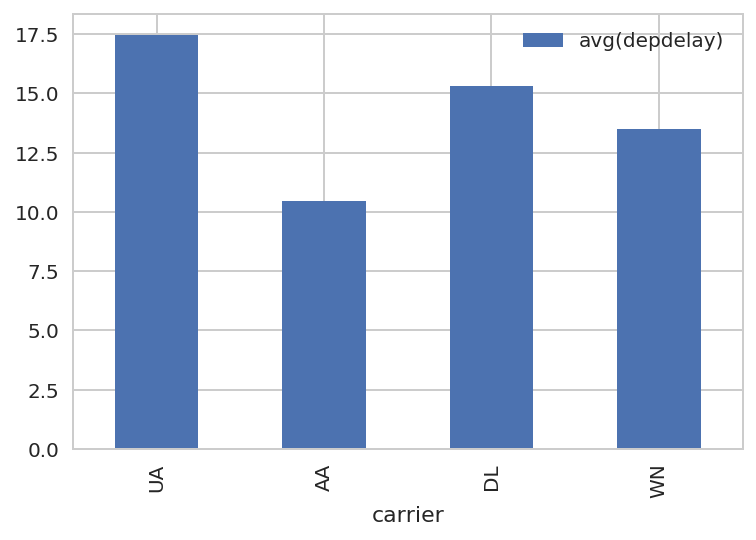

In [30]:
sql_result_df.toPandas().plot(kind='bar', x='carrier');

In [31]:
sql_result_df.unpersist()

DataFrame[carrier: string, avg(depdelay): double]

In [32]:
# Average Departure Delay by Carrier programmatically
(train_df
    .select(["carrier", "depdelay"])
    .groupBy(["carrier"])
    .avg("depdelay")).show()

+-------+------------------+
|carrier|     avg(depdelay)|
+-------+------------------+
|     UA|17.477878450696764|
|     AA| 10.45768118831622|
|     DL|15.316061660865241|
|     WN|13.491000418585182|
+-------+------------------+



### 4.4 Count of Departure Delays by Carrier (where delay>40 minutes)

We want to predict flight delays where depdelay > 40 minutes, so let’s explore this data. Below, we see that United Airlines and Delta have the highest count of flight delays for January and February 2017 (the training set).

In [33]:
# Count of Departure Delays by Carrier (where delay=40 minutes) using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT carrier, count(depdelay) 
                          |FROM train_flights 
                          |WHERE depdelay > 40 
                          |GROUP BY carrier
                        """))

sql_result_df.cache()

DataFrame[carrier: string, count(depdelay): bigint]

In [34]:
sql_result_df.show()

+-------+---------------+
|carrier|count(depdelay)|
+-------+---------------+
|     UA|           2420|
|     AA|            757|
|     DL|           1043|
|     WN|            244|
+-------+---------------+



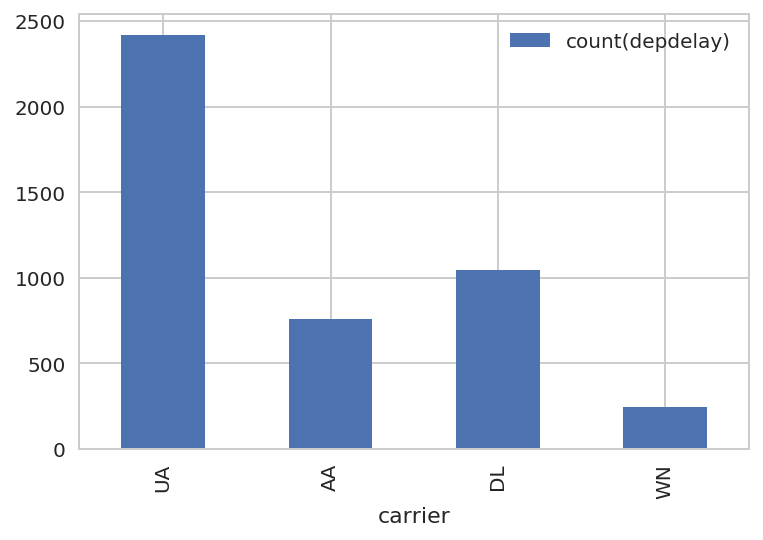

In [35]:
sql_result_df.toPandas().plot(kind='bar', x='carrier');

In [36]:
sql_result_df.unpersist()

DataFrame[carrier: string, count(depdelay): bigint]

In [37]:
# Count of Departure Delays by Carrier (where delay=40 minutes) programmatically
(train_df
    .select(["carrier", "depdelay"])
    .where("depdelay > 40")
    .groupBy(["carrier"])
    .count()).show()

+-------+-----+
|carrier|count|
+-------+-----+
|     UA| 2420|
|     AA|  757|
|     DL| 1043|
|     WN|  244|
+-------+-----+



### 4.5 Count of Departure Delays by Day of the Week (1=Monday, 7=Sunday)

In the query below, we see that Monday, Tuesday and Sunday have the highest count of flight delays.

In [38]:
### Count of Departure Delays by Day of the Week (where delay=40 minutes) using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT dofW, count(depdelay) 
                          |FROM train_flights 
                          |WHERE depdelay > 40 
                          |GROUP BY dofW 
                          |ORDER BY dofW
                        """))

sql_result_df.cache()

DataFrame[dofW: int, count(depdelay): bigint]

In [39]:
sql_result_df.show()

+----+---------------+
|dofW|count(depdelay)|
+----+---------------+
|   1|            940|
|   2|            712|
|   3|            482|
|   4|            626|
|   5|            579|
|   6|            424|
|   7|            701|
+----+---------------+



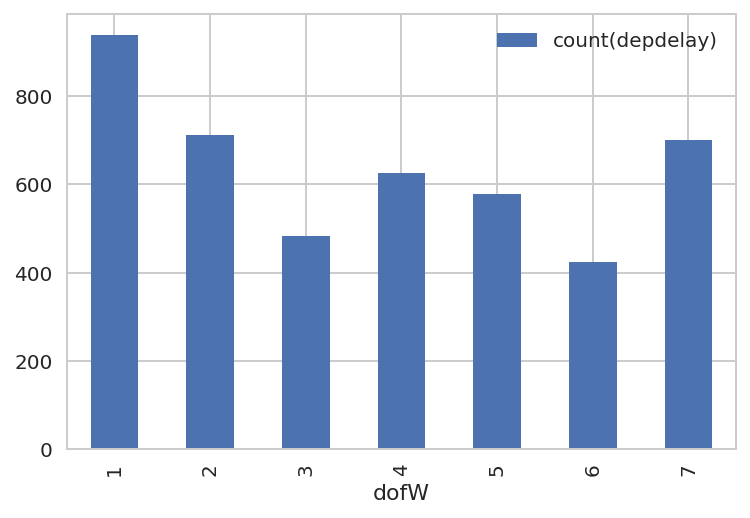

In [40]:
sql_result_df.toPandas().plot(kind='bar', x='dofW');

However, we can see that the days are marked as 1, 2, ... ,7 and not Monday, Tuesday, ... ,Sunday. We can develop a UserDefined function to get the custom labels. UDF (User defined functions) and UDAF (User defined aggregate functions) are key components of big data languages such as Pig and Hive. They allow to extend the language constructs to do adhoc processing on distributed dataset. This can be also applied to Spark.

#### 4.5.1 Create a new weekday column Using a UDF with DataFrame:

In [41]:
# Map from weekday number to actual weekday string
weekday = {1:"Monday", 2:"Tuesday", 3:"Wednesday",  4:"Thursday", 5:"Friday", 6:"Saturday", 7:"Sunday"}

In [42]:
# Define a udf
udfdofwToweekday = udf(lambda x: weekday[x], StringType())

In [43]:
# Instead of a lambda function as in the above cell we could have also defined as a function and registered that as a udf
# def dofwToweekday(x):
#    return weekday[x]
# udfdofwToweekday = udf(dofwToweekday, StringType())

In [44]:
# Create a new column appying the udf
sql_result_df = sql_result_df.withColumn("weekday", udfdofwToweekday("dofW"))
sql_result_df.cache()

DataFrame[dofW: int, count(depdelay): bigint, weekday: string]

In [45]:
sql_result_df.show()

+----+---------------+---------+
|dofW|count(depdelay)|  weekday|
+----+---------------+---------+
|   1|            940|   Monday|
|   2|            712|  Tuesday|
|   3|            482|Wednesday|
|   4|            626| Thursday|
|   5|            579|   Friday|
|   6|            424| Saturday|
|   7|            701|   Sunday|
+----+---------------+---------+



In the below post we now we can see that days are marked by their respective string names.

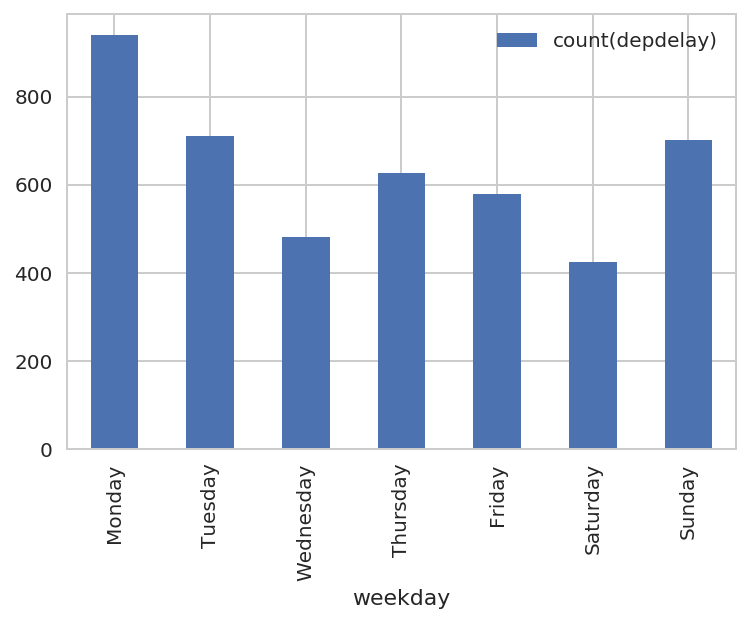

In [46]:
sql_result_df.toPandas()[['weekday', 'count(depdelay)']].plot(kind='bar', x='weekday');

In [47]:
sql_result_df.unpersist()

DataFrame[dofW: int, count(depdelay): bigint, weekday: string]

#### 4.5.2 Create a new weekday column Using CASE WHEN THEN with SQL:

We can achieve the same exact result without using any `udf` but by using `CASE WHEN THEN ELSE` constructs.

In [48]:
spark.sql(strip_margin(
        """SELECT 
          |    dofW, 
          |    CASE
          |        WHEN dofW = 1 THEN 'Monday'
          |        WHEN dofW = 2 THEN 'Tuesday'
          |        WHEN dofW = 3 THEN 'Wednesday'
          |        WHEN dofW = 4 THEN 'Thursday'
          |        WHEN dofW = 5 THEN 'Friday'
          |        WHEN dofW = 6 THEN 'Saturday'
          |        WHEN dofW = 7 THEN 'Sunday'
          |        ELSE 'Unknown'
          |    END as weekday,
          |    count(depdelay) 
          |FROM train_flights 
          |WHERE depdelay > 40 
          |GROUP BY dofW 
          |ORDER BY dofW
        """)).show()

+----+---------+---------------+
|dofW|  weekday|count(depdelay)|
+----+---------+---------------+
|   1|   Monday|            940|
|   2|  Tuesday|            712|
|   3|Wednesday|            482|
|   4| Thursday|            626|
|   5|   Friday|            579|
|   6| Saturday|            424|
|   7|   Sunday|            701|
+----+---------+---------------+



#### 4.5.3 Use a UDF on the DataFrame on the fly to create a new DataFrame with weekday column:

In [49]:
# Count of Departure Delays by Day of the Week (where delay=40 minutes) programatically
# We can replicate same aliasing using programatic syntax
(train_df
    .select(["dofW", udfdofwToweekday("dofW").alias("weekday")])
    .where("depdelay > 40")
    .groupBy(["dofW", "weekday"])
    .count()
    .orderBy(["dofW"])).show()

+----+---------+-----+
|dofW|  weekday|count|
+----+---------+-----+
|   1|   Monday|  940|
|   2|  Tuesday|  712|
|   3|Wednesday|  482|
|   4| Thursday|  626|
|   5|   Friday|  579|
|   6| Saturday|  424|
|   7|   Sunday|  701|
+----+---------+-----+



#### 4.5.4 Use a UDF with SQL to create a new column weekday:

In [50]:
# in order to use an udf with sql it needs to be registerd to sqlContext
sqlContext.udf.register("udfdofwToweekday", lambda dofW: weekday[dofW], StringType())

<function __main__.<lambda>>

In [51]:
### Count of Departure Delays by Day of the Week (where delay=40 minutes)
sql_result_df = spark.sql(strip_margin(
                        """SELECT dofW, udfdofwToweekday(dofW) as weekday, count(depdelay) 
                          |FROM train_flights 
                          |WHERE depdelay > 40 
                          |GROUP BY dofW, weekday 
                          |ORDER BY dofW
                        """))

In [52]:
sql_result_df.show()

+----+---------+---------------+
|dofW|  weekday|count(depdelay)|
+----+---------+---------------+
|   1|   Monday|            940|
|   2|  Tuesday|            712|
|   3|Wednesday|            482|
|   4| Thursday|            626|
|   5|   Friday|            579|
|   6| Saturday|            424|
|   7|   Sunday|            701|
+----+---------+---------------+



### 4.6 Count of Departure Delays by Hour of Day

In the query below, we see that the hours between 13:00-19:00 have the highest count of flight delays.

In [53]:
# Count of Departure Delays by Hour of Day using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT crsdephour, count(depdelay) as total 
                          |FROM train_flights 
                          |WHERE depdelay > 40 
                          |GROUP BY crsdephour 
                          |ORDER BY crsdephour
                        """))

sql_result_df.cache()

DataFrame[crsdephour: int, total: bigint]

In [54]:
sql_result_df.show(10)

+----------+-----+
|crsdephour|total|
+----------+-----+
|         0|    9|
|         1|    1|
|         5|   15|
|         6|   68|
|         7|  112|
|         8|  190|
|         9|  175|
|        10|  284|
|        11|  280|
|        12|  227|
+----------+-----+
only showing top 10 rows



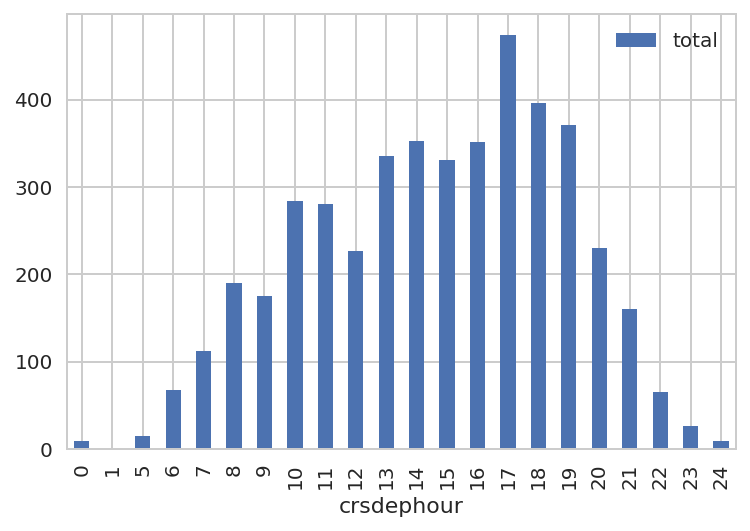

In [55]:
sql_result_df.toPandas().plot(kind='bar', x='crsdephour');

In [56]:
sql_result_df.unpersist()

DataFrame[crsdephour: int, total: bigint]

In [57]:
# Count of Departure Delays by Hour of Day using SQL programmatically
(train_df
        .select(["crsdephour", "depdelay"])
        .where("depdelay > 40")
        .groupBy(["crsdephour"])
        .count()
        .withColumnRenamed("count", "total")
        .orderBy(["crsdephour"], ascending=[1])).show(10)

+----------+-----+
|crsdephour|total|
+----------+-----+
|         0|    9|
|         1|    1|
|         5|   15|
|         6|   68|
|         7|  112|
|         8|  190|
|         9|  175|
|        10|  284|
|        11|  280|
|        12|  227|
+----------+-----+
only showing top 10 rows



### 4.7 Count of Departure Delays by Origin

In the query below, we see that the origin airports Chicago and Atlanta have the highest count of flight delays.

In [58]:
# Count of Departure Delays by Origin using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT origin, count(depdelay) as total 
                          |FROM train_flights 
                          |WHERE depdelay > 40 
                          |GROUP BY origin 
                          |ORDER BY total desc
                        """))

sql_result_df.cache()

DataFrame[origin: string, total: bigint]

In [59]:
sql_result_df.show()

+------+-----+
|origin|total|
+------+-----+
|   ORD|  679|
|   ATL|  637|
|   SFO|  542|
|   EWR|  518|
|   DEN|  484|
|   IAH|  447|
|   LGA|  432|
|   MIA|  429|
|   BOS|  296|
+------+-----+



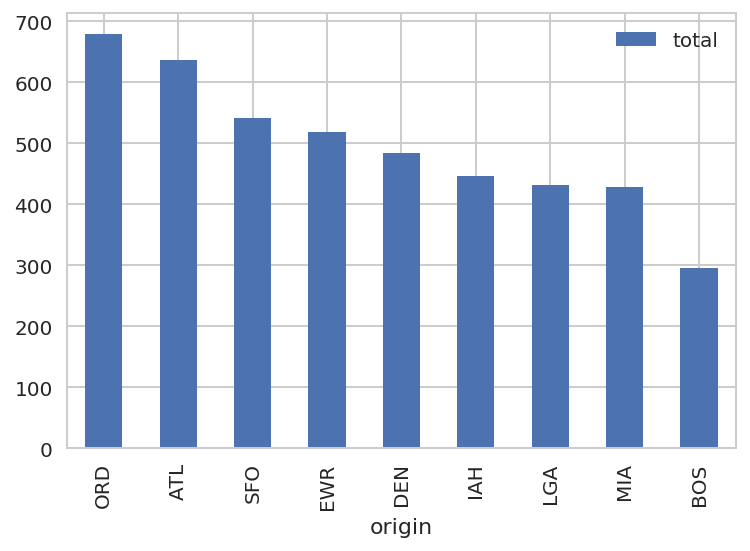

In [60]:
sql_result_df.toPandas().plot(kind='bar', x='origin');

In [61]:
sql_result_df.unpersist()

DataFrame[origin: string, total: bigint]

In [62]:
# Count of Departure Delays by Origin programmatically
(train_df
    .select(["origin", "depdelay"])
    .where("depdelay > 40")
    .groupBy(["origin"])
    .count()
    .withColumnRenamed("count", "total")
    .orderBy(["total"], ascending=[0])).show()

+------+-----+
|origin|total|
+------+-----+
|   ORD|  679|
|   ATL|  637|
|   SFO|  542|
|   EWR|  518|
|   DEN|  484|
|   IAH|  447|
|   LGA|  432|
|   MIA|  429|
|   BOS|  296|
+------+-----+



### 4.8 Count of Departure Delays by Destination

In the query below, we see that the destination airports San Francisco and Newark have the highest count of flight delays.

In [63]:
# Count of Departure Delays by Destination using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT dest, count(depdelay) as total 
                          |FROM train_flights 
                          |WHERE depdelay > 40 
                          |GROUP BY dest 
                          |ORDER BY total desc
                        """))

sql_result_df.cache()

DataFrame[dest: string, total: bigint]

In [64]:
sql_result_df.show()

+----+-----+
|dest|total|
+----+-----+
| SFO|  711|
| EWR|  620|
| ORD|  593|
| ATL|  547|
| LGA|  535|
| DEN|  397|
| MIA|  385|
| BOS|  343|
| IAH|  333|
+----+-----+



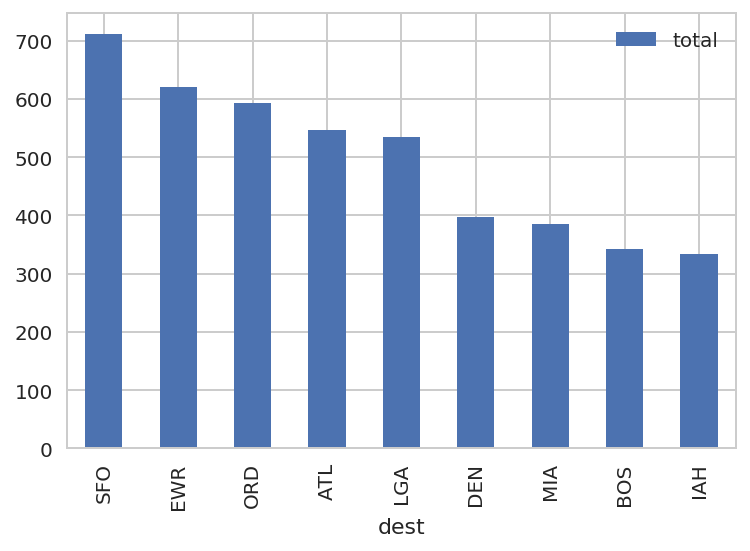

In [65]:
sql_result_df.toPandas().plot(kind='bar', x='dest');

In [66]:
sql_result_df.unpersist()

DataFrame[dest: string, total: bigint]

In [67]:
# Count of Departure Delays by Destination programmatically
(train_df
    .select(["dest", "depdelay"])
    .where("depdelay > 40")
    .groupBy(["dest"])
    .count()
    .withColumnRenamed("count", "total")
    .orderBy(["total"], ascending=[0])).show()

+----+-----+
|dest|total|
+----+-----+
| SFO|  711|
| EWR|  620|
| ORD|  593|
| ATL|  547|
| LGA|  535|
| DEN|  397|
| MIA|  385|
| BOS|  343|
| IAH|  333|
+----+-----+



### 4.9 Count of Departure Delays by Origin, Destination

In the query below, we see the count of departure delays by Origin and destination. The routes ORD -> SFO and DEN -> SFO have the highest delays, maybe because of weather in January and February. Adding weather to this dataset would give better results, but that is left as an exercise for the reader.

In [68]:
# Count of Departure Delays by Origin, Destination using SQL
sql_result_df = spark.sql(strip_margin(
                        """SELECT origin, dest, count(depdelay) as total 
                          |FROM train_flights 
                          |WHERE depdelay > 40 
                          |GROUP BY origin, dest 
                          |ORDER BY count(depdelay) desc
                        """))

sql_result_df.cache()

DataFrame[origin: string, dest: string, total: bigint]

In [69]:
sql_result_df.show()

+------+----+-----+
|origin|dest|total|
+------+----+-----+
|   DEN| SFO|  172|
|   ORD| SFO|  168|
|   ATL| LGA|  155|
|   ATL| EWR|  141|
|   SFO| DEN|  134|
|   LGA| ATL|  130|
|   ORD| EWR|  122|
|   SFO| ORD|  118|
|   EWR| ORD|  115|
|   ORD| LGA|  100|
|   IAH| SFO|   98|
|   IAH| EWR|   94|
|   MIA| LGA|   92|
|   ORD| ATL|   88|
|   LGA| ORD|   88|
|   ATL| SFO|   87|
|   LGA| MIA|   81|
|   SFO| EWR|   79|
|   EWR| SFO|   77|
|   ORD| DEN|   76|
+------+----+-----+
only showing top 20 rows



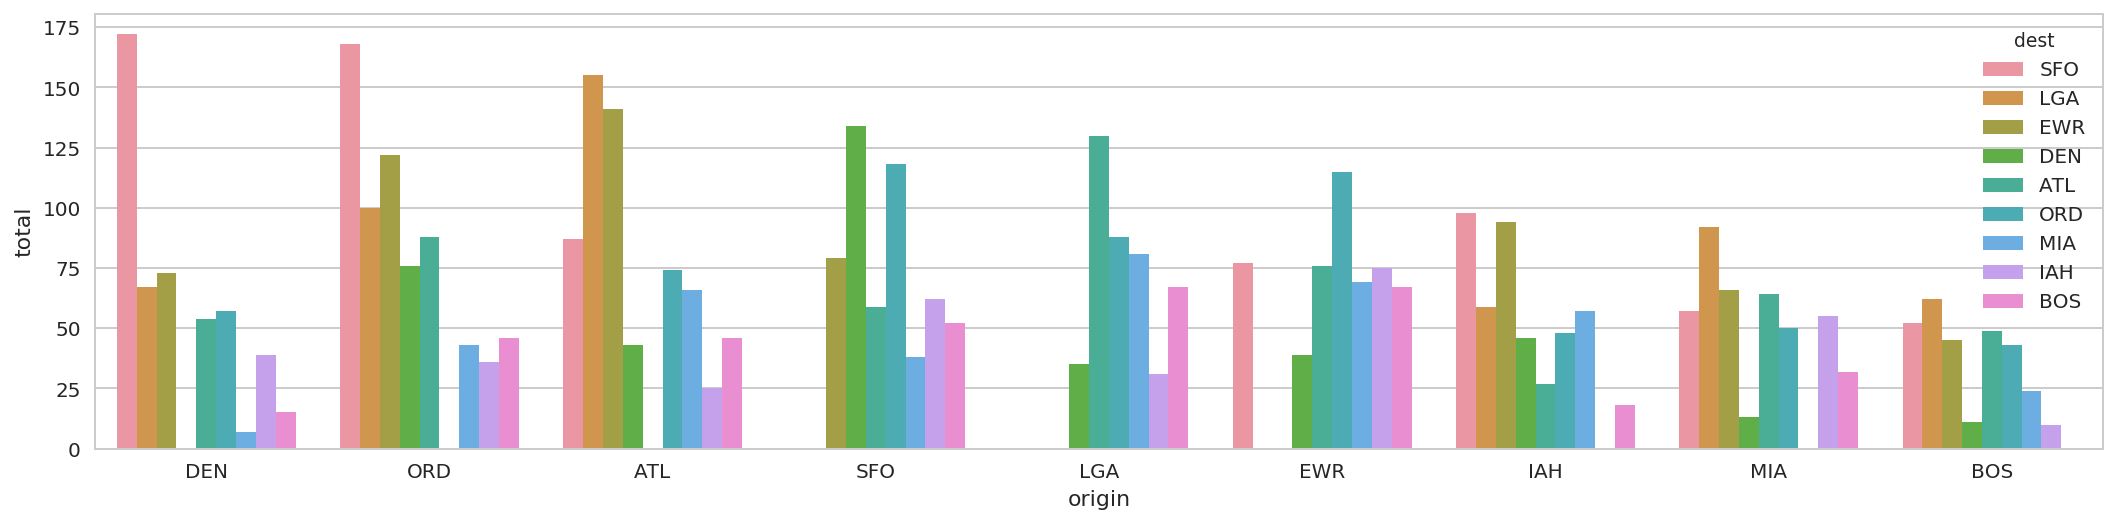

In [70]:
plt.figure(figsize=(18,4))
sns.barplot(x="origin", y="total", hue="dest", data=sql_result_df.toPandas());

In [71]:
sql_result_df.unpersist()

DataFrame[origin: string, dest: string, total: bigint]

In [72]:
# Count of Departure Delays by Origin, Destination programmatically
(train_df
    .select(["origin", "dest"])
    .where("depdelay > 40")
    .groupBy(["origin", "dest"])
    .count()
    .withColumnRenamed("count", "total")
    .orderBy(["total"], ascending=[0])).show()

+------+----+-----+
|origin|dest|total|
+------+----+-----+
|   DEN| SFO|  172|
|   ORD| SFO|  168|
|   ATL| LGA|  155|
|   ATL| EWR|  141|
|   SFO| DEN|  134|
|   LGA| ATL|  130|
|   ORD| EWR|  122|
|   SFO| ORD|  118|
|   EWR| ORD|  115|
|   ORD| LGA|  100|
|   IAH| SFO|   98|
|   IAH| EWR|   94|
|   MIA| LGA|   92|
|   LGA| ORD|   88|
|   ORD| ATL|   88|
|   ATL| SFO|   87|
|   LGA| MIA|   81|
|   SFO| EWR|   79|
|   EWR| SFO|   77|
|   ORD| DEN|   76|
+------+----+-----+
only showing top 20 rows



### 4.10 Add labels for Delayed Flights and Count

We can use Spark Bucketizer to split the dataset into delayed and not delayed flights with a delayed 0/1 column. Then, the resulting total counts are displayed. Grouping the data by the delayed field and counting the number of instances in each group shows that there are roughly eight times as many not delayed samples as delayed samples.

In [73]:
train_df.show(5)

+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|
|   7|     AA|   LGA| ATL|        13|    1343.0|     0.0|    1620.0|     0.0|         157.0| 762.0|
|   7|     AA|   MIA| ATL|         9|     939.0|     0.0|    1137.0|    10.0|         118.0| 594.0|
|   7|     AA|   ORD| MIA|        20|    2020.0|     0.0|      26.0|     0.0|         186.0|1197.0|
|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|
+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
only showing top 5 rows



In [74]:
# User Bucketizer to split the data into custom buckets
bucketizer = Bucketizer(splits=[0.0, 40.0, float("inf")], inputCol="depdelay", outputCol="delayed")

In [75]:
train_df = bucketizer.transform(train_df).cache()

In [76]:
train_df.groupBy("delayed").count().show()

+-------+-----+
|delayed|count|
+-------+-----+
|    0.0|36790|
|    1.0| 4558|
+-------+-----+



In [77]:
train_df.select(["dofW", "carrier", "origin", "dest", "depdelay", "delayed"]).sample(fraction=0.01, withReplacement=False, seed=rnd_seed).show()

+----+-------+------+----+--------+-------+
|dofW|carrier|origin|dest|depdelay|delayed|
+----+-------+------+----+--------+-------+
|   7|     DL|   MIA| LGA|     3.0|    0.0|
|   7|     WN|   LGA| ATL|     0.0|    0.0|
|   7|     WN|   LGA| DEN|     0.0|    0.0|
|   7|     UA|   IAH| MIA|     1.0|    0.0|
|   7|     UA|   SFO| ORD|     0.0|    0.0|
|   7|     UA|   EWR| ORD|     0.0|    0.0|
|   1|     AA|   LGA| ORD|     0.0|    0.0|
|   1|     DL|   EWR| ATL|    10.0|    0.0|
|   1|     DL|   LGA| DEN|    17.0|    0.0|
|   1|     UA|   EWR| IAH|     0.0|    0.0|
|   1|     UA|   LGA| DEN|     0.0|    0.0|
|   1|     UA|   EWR| IAH|    83.0|    1.0|
|   1|     UA|   IAH| SFO|    70.0|    1.0|
|   2|     DL|   ATL| BOS|     0.0|    0.0|
|   2|     DL|   MIA| ATL|     0.0|    0.0|
|   2|     UA|   IAH| ORD|     9.0|    0.0|
|   2|     AA|   DEN| MIA|     0.0|    0.0|
|   2|     AA|   SFO| MIA|     0.0|    0.0|
|   2|     AA|   ORD| BOS|     0.0|    0.0|
|   3|     AA|   LGA| MIA|     0

### 4.11 Create a stacked bar plot of count of departure delays by Origin

In the query below, we see the count of not delayed (0=dark blue) and delayed (1=light blue) flights by origin.

In [78]:
# Count of Departure Delays by Origin
result_df = (train_df
                .select(["origin", "delayed"])
                .groupBy(["origin", "delayed"])
                .count()
                .orderBy(["delayed"]))
result_df.cache()

DataFrame[origin: string, delayed: double, count: bigint]

In [79]:
result_df.show(15)

+------+-------+-----+
|origin|delayed|count|
+------+-------+-----+
|   DEN|    0.0| 3773|
|   BOS|    0.0| 3388|
|   LGA|    0.0| 4550|
|   EWR|    0.0| 3693|
|   MIA|    0.0| 3991|
|   IAH|    0.0| 3218|
|   ORD|    0.0| 5607|
|   ATL|    0.0| 5322|
|   SFO|    0.0| 3248|
|   LGA|    1.0|  442|
|   MIA|    1.0|  434|
|   IAH|    1.0|  455|
|   EWR|    1.0|  526|
|   ORD|    1.0|  693|
|   SFO|    1.0|  557|
+------+-------+-----+
only showing top 15 rows



#### 4.11.1 Leverage Panda's pivot method to do a stacked bar plot:

In [80]:
pdf = result_df.toPandas()

In [81]:
print(pdf.head(15))

   origin  delayed  count
0     DEN      0.0   3773
1     BOS      0.0   3388
2     LGA      0.0   4550
3     EWR      0.0   3693
4     MIA      0.0   3991
5     IAH      0.0   3218
6     ORD      0.0   5607
7     ATL      0.0   5322
8     SFO      0.0   3248
9     LGA      1.0    442
10    MIA      1.0    434
11    IAH      1.0    455
12    EWR      1.0    526
13    ORD      1.0    693
14    SFO      1.0    557


The above pandas dataframe needs to be pivoted with origin as index to create the bar plot.

In [82]:
pdf = pdf.pivot(index='origin', columns='delayed', values='count').sort_index()

In [83]:
print(pdf.head(15))

delayed   0.0  1.0
origin            
ATL      5322  649
BOS      3388  306
DEN      3773  496
EWR      3693  526
IAH      3218  455
LGA      4550  442
MIA      3991  434
ORD      5607  693
SFO      3248  557


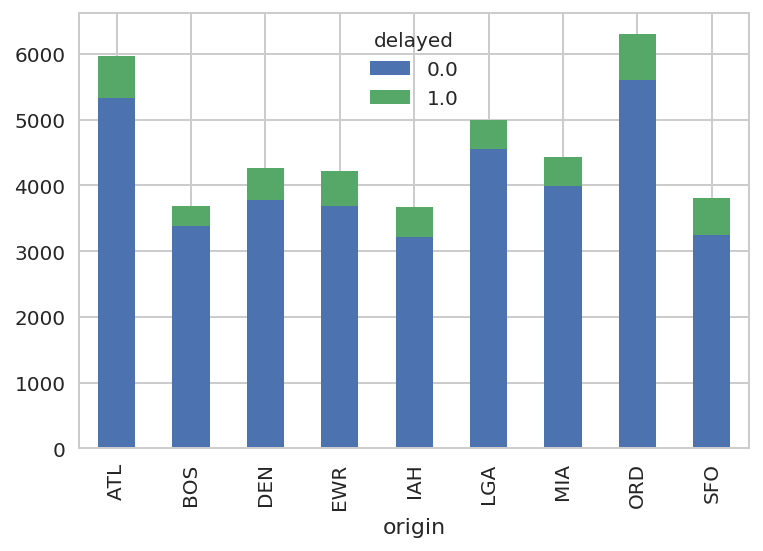

In [84]:
pdf.plot.bar(stacked=True);

#### 4.11.2 Can we do the same pivot using Spark?

In [85]:
# careful! we are using train_df and not result_df. Pivot will only work with a Grouped DF is Spark
train_df.select(["origin", "delayed"]).groupBy(["origin"]).pivot('delayed').count().orderBy('origin').show(15)

+------+----+---+
|origin| 0.0|1.0|
+------+----+---+
|   ATL|5322|649|
|   BOS|3388|306|
|   DEN|3773|496|
|   EWR|3693|526|
|   IAH|3218|455|
|   LGA|4550|442|
|   MIA|3991|434|
|   ORD|5607|693|
|   SFO|3248|557|
+------+----+---+



**Voila!** The same result as above from pandas dataframe pivot method

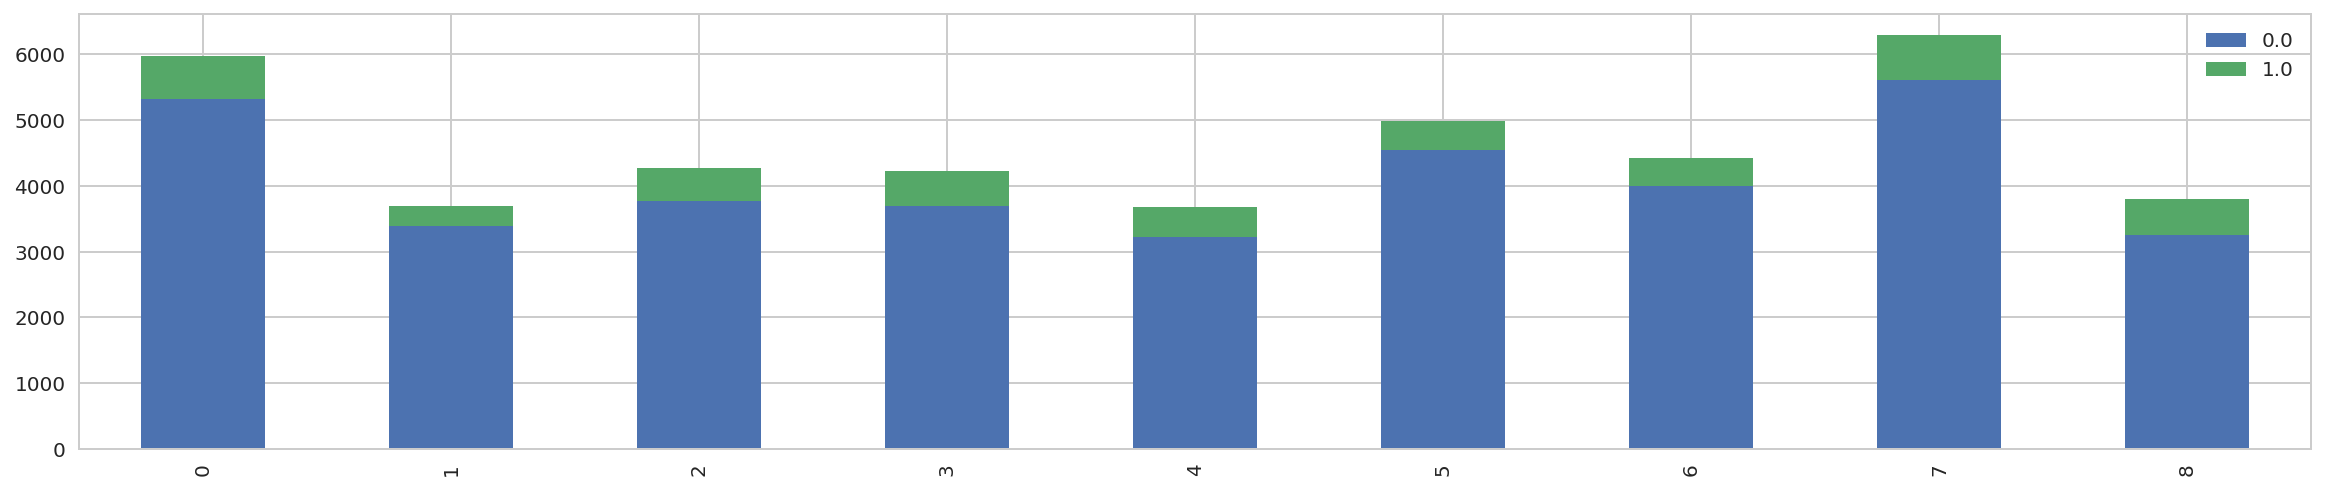

In [86]:
(train_df.select(["origin", "delayed"])
         .groupBy(["origin"]).pivot('delayed').count().orderBy('origin')
         .toPandas()
         .plot.bar(stacked=True, figsize=(20, 4)));

In [87]:
train_df.show(10)

+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+-------+
|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|delayed|
+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+-------+
|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|    0.0|
|   7|     AA|   LGA| ATL|        13|    1343.0|     0.0|    1620.0|     0.0|         157.0| 762.0|    0.0|
|   7|     AA|   MIA| ATL|         9|     939.0|     0.0|    1137.0|    10.0|         118.0| 594.0|    0.0|
|   7|     AA|   ORD| MIA|        20|    2020.0|     0.0|      26.0|     0.0|         186.0|1197.0|    0.0|
|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|    0.0|
|   7|     AA|   ORD| DEN|        13|    1345.0|     0.0|    1527.0|     0.0|         162.0| 888.0|    0.0|
|   7|     AA|   DEN| MIA|  

#### 4.11.3 Can we do the same using SQL Pivot function in Spark?

**With Spark 2.4.0 SQL equivalent pivot function was introduced**. Now we can achieve the same same with one query instead to DF + SQL combination.

In [88]:
train_df.createOrReplaceTempView("train_df")

In [89]:
spark.sql("SELECT origin, delayed FROM train_df").show()

+------+-------+
|origin|delayed|
+------+-------+
|   ATL|    0.0|
|   LGA|    0.0|
|   MIA|    0.0|
|   ORD|    0.0|
|   LGA|    0.0|
|   ORD|    0.0|
|   DEN|    0.0|
|   MIA|    0.0|
|   DEN|    0.0|
|   ORD|    0.0|
|   IAH|    0.0|
|   MIA|    1.0|
|   MIA|    0.0|
|   DEN|    0.0|
|   ORD|    0.0|
|   MIA|    1.0|
|   MIA|    0.0|
|   MIA|    1.0|
|   MIA|    0.0|
|   MIA|    0.0|
+------+-------+
only showing top 20 rows



In [90]:
(spark.sql(strip_margin(
"""SELECT * 
     FROM (SELECT origin, delayed FROM train_df)
     PIVOT (
        COUNT(1)
        FOR delayed IN (0.0, 1.0)
     )
   ORDER BY origin
"""))).show()

+------+----+---+
|origin| 0.0|1.0|
+------+----+---+
|   ATL|5322|649|
|   BOS|3388|306|
|   DEN|3773|496|
|   EWR|3693|526|
|   IAH|3218|455|
|   LGA|4550|442|
|   MIA|3991|434|
|   ORD|5607|693|
|   SFO|3248|557|
+------+----+---+



In [91]:
# above query in one line
(spark.sql(
    "SELECT * FROM (SELECT origin, delayed FROM train_df) PIVOT (COUNT(1) FOR delayed IN (0.0, 1.0)) ORDER BY origin"
)).show()

+------+----+---+
|origin| 0.0|1.0|
+------+----+---+
|   ATL|5322|649|
|   BOS|3388|306|
|   DEN|3773|496|
|   EWR|3693|526|
|   IAH|3218|455|
|   LGA|4550|442|
|   MIA|3991|434|
|   ORD|5607|693|
|   SFO|3248|557|
+------+----+---+



### 4.12 Done with Data Exploration: Cleanup

In [92]:
# For temporary views you can use Catalog.dropTempView:
spark.catalog.dropTempView("train_df")
spark.catalog.dropTempView("train_flights")

## 5. Stratified Sampling

In order to ensure that our model is sensitive to the delayed samples, we can put the two sample types on the same footing using stratified sampling. The DataFrames `sampleBy()` function does this when provided with fractions of each sample type to be returned. Here, we're keeping all instances of delayed, but downsampling the not delayed instances to 29%, then displaying the results.

In [93]:
train_df.groupBy("delayed").count().show()

+-------+-----+
|delayed|count|
+-------+-----+
|    0.0|36790|
|    1.0| 4558|
+-------+-----+



In [94]:
# count of delayed=0.0
count_not_delayed = train_df.groupBy("delayed").count().select(["count"]).where("delayed = 0.0").first()[0]

In [95]:
# count of delayed=1.0
count_delayed = train_df.groupBy("delayed").count().select(["count"]).where("delayed = 1.0").first()[0]

In [96]:
total = train_df.count()

In [97]:
count_not_delayed, count_delayed, total

(36790, 4558, 41348)

In [98]:
print("Not Delayed: {0}%, Delayed: {1}%".format(np.round(100 * count_not_delayed / total, 2), np.round(100 * count_delayed / total, 2)))

Not Delayed: 88.98%, Delayed: 11.02%


In [99]:
# specify the exact fraction desired from each key as a dictionary
fractions = {0.0: 0.29, 1.0: 1.0}

In [100]:
strat_train_df = train_df.stat.sampleBy('delayed', fractions, seed=rnd_seed)

In [101]:
strat_train_df.groupBy("delayed").count().show()

+-------+-----+
|delayed|count|
+-------+-----+
|    0.0|10555|
|    1.0| 4558|
+-------+-----+



In [102]:
# count of delayed=0.0
count_not_delayed = strat_train_df.groupBy("delayed").count().select(["count"]).where("delayed = 0.0").first()[0]

# count of delayed=1.0
count_delayed = strat_train_df.groupBy("delayed").count().select(["count"]).where("delayed = 1.0").first()[0]

total = count_not_delayed + count_delayed

In [103]:
print("Not Delayed: {0}%, Delayed: {1}%".format(np.round(100 * count_not_delayed / total, 2), np.round(100 * count_delayed / total, 2)))

Not Delayed: 69.84%, Delayed: 30.16%


In [104]:
strat_train_df.show(5)

+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+-------+
|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|delayed|
+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+-------+
|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|    0.0|
|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|    0.0|
|   7|     AA|   DEN| ORD|        12|    1235.0|     0.0|    1600.0|     0.0|         145.0| 888.0|    0.0|
|   7|     AA|   MIA| IAH|        20|    2045.0|    80.0|    2238.0|    63.0|         173.0| 964.0|    1.0|
|   7|     AA|   MIA| LGA|        20|    2025.0|     0.0|    2325.0|     0.0|         180.0|1096.0|    0.0|
+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+-------+
only showing top 5 rows



In [105]:
# Done with stratifying, we can drop the column
strat_train_df = strat_train_df.drop("delayed")

In [106]:
strat_train_df.show(5)

+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|dofW|carrier|origin|dest|crsdephour|crsdeptime|depdelay|crsarrtime|arrdelay|crselapsedtime|  dist|
+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
|   7|     AA|   ATL| LGA|        17|    1700.0|     0.0|    1912.0|     0.0|         132.0| 762.0|
|   7|     AA|   LGA| MIA|         7|     700.0|     0.0|    1017.0|     0.0|         197.0|1096.0|
|   7|     AA|   DEN| ORD|        12|    1235.0|     0.0|    1600.0|     0.0|         145.0| 888.0|
|   7|     AA|   MIA| IAH|        20|    2045.0|    80.0|    2238.0|    63.0|         173.0| 964.0|
|   7|     AA|   MIA| LGA|        20|    2025.0|     0.0|    2325.0|     0.0|         180.0|1096.0|
+----+-------+------+----+----------+----------+--------+----------+--------+--------------+------+
only showing top 5 rows



## 6. Features Array

To build a classifier model, you extract the features that most contribute to the classification. In this scenario, we will build a tree to predict the label of delayed or not based on the following features:

+ Label: 
    - delayed = 0
    - Delayed = 1 if delay > 40 minutes
+ Features -> {day of the week, scheduled departure time, scheduled arrival time, carrier, scheduled elapsed time, origin, destination, distance}

In order for the features to be used by a machine learning algorithm, they must be transformed and put into feature vectors, which are vectors of numbers representing the value for each feature.

### Using the Spark ML Package

The [ML package](http://spark.apache.org/docs/latest/ml-guide.html) is the newer library of machine learning routines. [Spark ML provides a uniform set of high-level APIs built on top of DataFrames](http://spark.apache.org/docs/latest/ml-pipeline.html#pipeline-components).

![](assets/ml-pipeline.png)

We will use an ML Pipeline to pass the data through transformers in order to extract the features and an estimator to produce the model.

- Transformer: A Transformer is an algorithm which transforms one DataFrame into another DataFrame. We will use a transformer to get a DataFrame with a features vector column.
- Estimator: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. We will use a an estimator to train a model which can transform data to get predictions.
- Pipeline: A Pipeline chains multiple Transformers and Estimators together to specify a ML workflow.

## Feature Extraction and Pipelining

The ML package needs the label and feature vector to be added as columns to the input dataframe. We set up a pipeline to pass the data through transformers in order to extract the features and label. We use a StringIndexer to encode a string columns to a column of number indices. We use a OneHotEncoder to map a number indices column to a column of binary vectors, with at most a single one-value. Encoding categorical features allows decision trees to treat categorical features appropriately, improving performance. An example of StringIndexing and OneHotEncoding for carrier is shown below:

![](assets/example-category-encoding.png)

### 6.1 Use a combination of StringIndexer and OneHotEncoder to encode Categorical columns

**Experiment: Let's SringIndex the 'carrier' column**

In [107]:
colName = "carrier"

In [108]:
carrierIndexer = StringIndexer(inputCol=colName, outputCol="{0}_indexed".format(colName)).fit(strat_train_df)

In [109]:
indexed_df = carrierIndexer.transform(strat_train_df)

In [110]:
# create a new "carrier_indexed" column
(indexed_df.select(["origin", "dest", "carrier", "carrier_indexed"])
                .sample(fraction=0.001, withReplacement=False, seed=rnd_seed).show())

+------+----+-------+---------------+
|origin|dest|carrier|carrier_indexed|
+------+----+-------+---------------+
|   DEN| ORD|     UA|            0.0|
|   SFO| ORD|     UA|            0.0|
|   ATL| EWR|     DL|            1.0|
|   BOS| LGA|     DL|            1.0|
|   DEN| IAH|     UA|            0.0|
|   MIA| ORD|     AA|            2.0|
|   ORD| DEN|     UA|            0.0|
|   SFO| ATL|     UA|            0.0|
|   IAH| DEN|     UA|            0.0|
|   MIA| BOS|     AA|            2.0|
|   LGA| BOS|     DL|            1.0|
|   MIA| DEN|     AA|            2.0|
|   SFO| BOS|     UA|            0.0|
+------+----+-------+---------------+



In [111]:
# check the encoded carrier values
carrierIndexer.labels

['UA', 'DL', 'AA', 'WN']

In [112]:
# check the carrier code and index mapping 
indexed_df.select(["carrier", "carrier_indexed"]).distinct().show()

+-------+---------------+
|carrier|carrier_indexed|
+-------+---------------+
|     UA|            0.0|
|     DL|            1.0|
|     WN|            3.0|
|     AA|            2.0|
+-------+---------------+



**Experiment: Let's OneHotEncode the 'carrier' column**

`pyspark.ml.feature.OneHotEncoder` maps a column of category indices to a column of binary vectors, with at most a single one-value per row that indicates the input category index. For example with 5 categories, an input value of 2.0 would map to an output vector of [0.0, 0.0, 1.0, 0.0]. The last category is not included by default (configurable via dropLast) because it makes the vector entries sum up to one, and hence linearly dependent. So an input value of 4.0 maps to [0.0, 0.0, 0.0, 0.0]. Note that this is different from `scikit-learn's OneHotEncoder`, which keeps all categories. The output vectors are sparse.

In [113]:
carrierEncoder = OneHotEncoder(inputCol="{0}_indexed".format(colName), outputCol="{0}_encoded".format(colName))
encoded_df = carrierEncoder.transform(indexed_df)

In [114]:
(encoded_df.select(["origin", "dest", "carrier", "carrier_indexed", "carrier_encoded"])
                 .sample(fraction=0.001, withReplacement=False, seed=rnd_seed).show())

+------+----+-------+---------------+---------------+
|origin|dest|carrier|carrier_indexed|carrier_encoded|
+------+----+-------+---------------+---------------+
|   DEN| ORD|     UA|            0.0|  (3,[0],[1.0])|
|   SFO| ORD|     UA|            0.0|  (3,[0],[1.0])|
|   ATL| EWR|     DL|            1.0|  (3,[1],[1.0])|
|   BOS| LGA|     DL|            1.0|  (3,[1],[1.0])|
|   DEN| IAH|     UA|            0.0|  (3,[0],[1.0])|
|   MIA| ORD|     AA|            2.0|  (3,[2],[1.0])|
|   ORD| DEN|     UA|            0.0|  (3,[0],[1.0])|
|   SFO| ATL|     UA|            0.0|  (3,[0],[1.0])|
|   IAH| DEN|     UA|            0.0|  (3,[0],[1.0])|
|   MIA| BOS|     AA|            2.0|  (3,[2],[1.0])|
|   LGA| BOS|     DL|            1.0|  (3,[1],[1.0])|
|   MIA| DEN|     AA|            2.0|  (3,[2],[1.0])|
|   SFO| BOS|     UA|            0.0|  (3,[0],[1.0])|
+------+----+-------+---------------+---------------+



Note: The column vector is a SparseVector: (3,[0],[1.0]) means there are 3 elements and the 0th position has a 1.0. Similary, (3,[],[]) means that all positions have zeros. All position with 0's also siginifies a category value.

**Experiment: Let's OneHotEncode the 'carrier' column With dropLast=False**

In [115]:
carrierEncoder = OneHotEncoder(inputCol="{0}_indexed".format(colName), outputCol="{0}_encoded".format(colName), dropLast=False)
encoded_df = carrierEncoder.transform(indexed_df)

In [116]:
(encoded_df.select(["origin", "dest", "carrier", "carrier_indexed", "carrier_encoded"])
                 .sample(fraction=0.001, withReplacement=False, seed=rnd_seed).show())

+------+----+-------+---------------+---------------+
|origin|dest|carrier|carrier_indexed|carrier_encoded|
+------+----+-------+---------------+---------------+
|   DEN| ORD|     UA|            0.0|  (4,[0],[1.0])|
|   SFO| ORD|     UA|            0.0|  (4,[0],[1.0])|
|   ATL| EWR|     DL|            1.0|  (4,[1],[1.0])|
|   BOS| LGA|     DL|            1.0|  (4,[1],[1.0])|
|   DEN| IAH|     UA|            0.0|  (4,[0],[1.0])|
|   MIA| ORD|     AA|            2.0|  (4,[2],[1.0])|
|   ORD| DEN|     UA|            0.0|  (4,[0],[1.0])|
|   SFO| ATL|     UA|            0.0|  (4,[0],[1.0])|
|   IAH| DEN|     UA|            0.0|  (4,[0],[1.0])|
|   MIA| BOS|     AA|            2.0|  (4,[2],[1.0])|
|   LGA| BOS|     DL|            1.0|  (4,[1],[1.0])|
|   MIA| DEN|     AA|            2.0|  (4,[2],[1.0])|
|   SFO| BOS|     UA|            0.0|  (4,[0],[1.0])|
+------+----+-------+---------------+---------------+



Note: Although the column vector is a still a SparseVector but the encoding is of same lenght in all rows because dropLast=False: Hence the  entry (3,[],[]) is the previous encoding scheme is now converted to (4,[0],[1.0]), which means there are 4 elements and the 0th position has a 1.0. Following that it means that there will be no combination where all position are 0's, there will always be a 1.0 in one of the positions.

#### 6.1.2 Use a VectorAssembler to put features into a feature vector column

In [117]:
(encoded_df.select(["carrier", "carrier_indexed", "carrier_encoded", "dist"])
                 .sample(fraction=0.001, withReplacement=False, seed=rnd_seed).show())

+-------+---------------+---------------+------+
|carrier|carrier_indexed|carrier_encoded|  dist|
+-------+---------------+---------------+------+
|     UA|            0.0|  (4,[0],[1.0])| 888.0|
|     UA|            0.0|  (4,[0],[1.0])|1846.0|
|     DL|            1.0|  (4,[1],[1.0])| 746.0|
|     DL|            1.0|  (4,[1],[1.0])| 184.0|
|     UA|            0.0|  (4,[0],[1.0])| 862.0|
|     AA|            2.0|  (4,[2],[1.0])|1197.0|
|     UA|            0.0|  (4,[0],[1.0])| 888.0|
|     UA|            0.0|  (4,[0],[1.0])|2139.0|
|     UA|            0.0|  (4,[0],[1.0])| 862.0|
|     AA|            2.0|  (4,[2],[1.0])|1258.0|
|     DL|            1.0|  (4,[1],[1.0])| 184.0|
|     AA|            2.0|  (4,[2],[1.0])|1709.0|
|     UA|            0.0|  (4,[0],[1.0])|2704.0|
+-------+---------------+---------------+------+



**Experiment: Let's choose only two features 'carrier_encoded' & 'dist'**

In [118]:
featureCols = ["carrier_encoded", "dist"]

In [119]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

In [120]:
assembled_df = assembler.transform(encoded_df)

**Result: SparseVector representation of the Feature Vectors**

In [121]:
(assembled_df.select(["carrier", "carrier_indexed", "carrier_encoded", "dist", "features"])
                .sample(fraction=0.001, withReplacement=False, seed=rnd_seed).show(truncate=False))

+-------+---------------+---------------+------+----------------------+
|carrier|carrier_indexed|carrier_encoded|dist  |features              |
+-------+---------------+---------------+------+----------------------+
|UA     |0.0            |(4,[0],[1.0])  |888.0 |(5,[0,4],[1.0,888.0]) |
|UA     |0.0            |(4,[0],[1.0])  |1846.0|(5,[0,4],[1.0,1846.0])|
|DL     |1.0            |(4,[1],[1.0])  |746.0 |(5,[1,4],[1.0,746.0]) |
|DL     |1.0            |(4,[1],[1.0])  |184.0 |(5,[1,4],[1.0,184.0]) |
|UA     |0.0            |(4,[0],[1.0])  |862.0 |(5,[0,4],[1.0,862.0]) |
|AA     |2.0            |(4,[2],[1.0])  |1197.0|(5,[2,4],[1.0,1197.0])|
|UA     |0.0            |(4,[0],[1.0])  |888.0 |(5,[0,4],[1.0,888.0]) |
|UA     |0.0            |(4,[0],[1.0])  |2139.0|(5,[0,4],[1.0,2139.0])|
|UA     |0.0            |(4,[0],[1.0])  |862.0 |(5,[0,4],[1.0,862.0]) |
|AA     |2.0            |(4,[2],[1.0])  |1258.0|(5,[2,4],[1.0,1258.0])|
|DL     |1.0            |(4,[1],[1.0])  |184.0 |(5,[1,4],[1.0,18

### 6.2 Combine StringIndexer, OneHotEncoder, VectorAssembler and a Transformer to put features into a feature vector column

**Let's OneHotEncode all the categorical columns:**

In [122]:
# categorical columns
categoricalColumns = ["carrier", "origin", "dest", "dofW"]

In [123]:
for cat in categoricalColumns:
    print("{0} has {1} distinct values.".format(cat, strat_train_df.select(cat).distinct().count()))

carrier has 4 distinct values.
origin has 9 distinct values.
dest has 9 distinct values.
dofW has 7 distinct values.


In [124]:
# String Indexers will encode string categorical columns into a column of numeric indices
stringIndexers = [StringIndexer(inputCol=colName, outputCol="{0}_indexed".format(colName)).fit(strat_train_df) for colName in categoricalColumns]

In [125]:
# OneHotEncoders map number indices column to column of binary vectors
encoders = [OneHotEncoder(inputCol="{0}_indexed".format(colName), outputCol="{0}_encoded".format(colName), dropLast=False) for colName in categoricalColumns]

In [126]:
# Below, a Bucketizer is used to add a label of delayed 0/1. 
labeler = Bucketizer(splits=[0.0, 40.0, float("inf")], inputCol="depdelay", outputCol="label")

In [127]:
featureCols = ["carrier_encoded", "dest_encoded", "origin_encoded", "dofW_encoded", "crsdephour", "crselapsedtime", "crsarrtime", "crsdeptime", "dist"]

In [128]:
# The VectorAssembler combines a given list of columns into a single feature vector #column.
assembler = VectorAssembler(inputCols=featureCols, outputCol="features") 

The result of running these transformers in a pipeline will be to add a label and features column to the dataset as shown below.

![](assets/add-label-features-column.png)

The final element in our pipeline is an estimator (a decision tree classifier), training on the vector of labels and features.

## 7. Create Decision Tree Estimator, set Label and Feature Columns

In [129]:
from pyspark.ml.classification import DecisionTreeClassifier
dTree = DecisionTreeClassifier(featuresCol='features', labelCol='label', predictionCol='prediction', maxDepth=5, maxBins=7000)

Below, we chain the indexers and tree in a Pipeline.

### 7.1 Setup pipeline with feature transformers and model estimator

In [130]:
steps = stringIndexers + encoders + [labeler, assembler, dTree]
steps

[StringIndexer_5e121755420b,
 StringIndexer_b053dbdbf6d0,
 StringIndexer_013d83784d0a,
 StringIndexer_31487e6521c9,
 OneHotEncoder_c32a91af696a,
 OneHotEncoder_92e1c97a689b,
 OneHotEncoder_cfab68d1723b,
 OneHotEncoder_6e026e0c3ca3,
 Bucketizer_4da46b88cfd3,
 VectorAssembler_b6b526df22b3,
 DecisionTreeClassifier_62f9f582312f]

In [131]:
pipeline = Pipeline(stages=steps)

## 8. Train the Model

We would like to determine which parameter values of the decision tree produce the best model. A common technique for model selection is k-fold cross-validation, where the data is randomly split into k partitions. Each partition is used once as the testing dataset, while the rest are used for training. Models are then generated using the training sets and evaluated with the testing sets, resulting in k model performance measurements. The model parameters leading to the highest performance metric produce the best model.

Spark ML supports k-fold cross-validation with a transformation/estimation pipeline to try out different combinations of parameters, using a process called grid search, where you set up the parameters to test, and a cross-validation evaluator to construct a model selection workflow.

Below, we use a ParamGridBuilder to construct the parameter grid. We define an Evaluator, which will evaluate the model by comparing the test label column with the test prediction column. We use a CrossValidator for model selection.

### 8.1 Set up a CrossValidator with the parameters, a tree estimator and evaluator

In [132]:
# set param grid to search through decision tree's maxDepth parameter for best model
# Deeper trees are potential more accurate, but are also more likely to overfit
paramGrid = ParamGridBuilder().addGrid(dTree.maxDepth, [4, 5, 6]).build()

In [133]:
#evaluator = BinaryClassificationEvaluator(rawPredictionCol='rawPrediction', labelCol="label", metricName="areaUnderROC")
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol="label", metricName="accuracy")

In [134]:
# Set up 3-fold cross validation with paramGrid
crossVal = CrossValidator(estimator=pipeline, evaluator=evaluator, estimatorParamMaps=paramGrid, numFolds=3)

The CrossValidator uses the Estimator Pipeline, the Parameter Grid, and the Classification Evaluator to fit the training data set and returns a model.

### 8.2 Use CrossValidator Estimator to fit the training data set

In [135]:
cvModel = crossVal.fit(strat_train_df)

The CrossValidator uses the ParamGridBuilder to iterate through the maxDepth parameter of the decision tree and evaluate the models, repeating 3 times per parameter value for reliable results.

Next, we can get the best decision tree model, in order to print out the decision tree and feature importances. (Note that the OneHotEncoders increases the number of features. In order to understand this printout better I built a tree without the encoders, which gave a slightly lower accuracy)

In [136]:
cvModel.bestModel.stages

[StringIndexer_5e121755420b,
 StringIndexer_b053dbdbf6d0,
 StringIndexer_013d83784d0a,
 StringIndexer_31487e6521c9,
 OneHotEncoder_c32a91af696a,
 OneHotEncoder_92e1c97a689b,
 OneHotEncoder_cfab68d1723b,
 OneHotEncoder_6e026e0c3ca3,
 Bucketizer_4da46b88cfd3,
 VectorAssembler_b6b526df22b3,
 DecisionTreeClassificationModel (uid=DecisionTreeClassifier_62f9f582312f) of depth 6 with 87 nodes]

### 8.3 Get the best Decision Tree Model

In [137]:
treeModel = cvModel.bestModel.stages[-1]
treeModel

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_62f9f582312f) of depth 6 with 87 nodes

In [138]:
type(treeModel)

pyspark.ml.classification.DecisionTreeClassificationModel

We find that the best tree model produced using the cross-validation process is one with a depth of 6. The toDebugString() function provides a print of the tree's decision nodes and final prediction outcomes at the end leaves. Below is a partial printout of the decision tree:

In [139]:
print(treeModel.toDebugString)

DecisionTreeClassificationModel (uid=DecisionTreeClassifier_62f9f582312f) of depth 6 with 87 nodes
  If (feature 32 <= 1018.5)
   If (feature 32 <= 779.5)
    If (feature 31 <= 913.5)
     If (feature 33 <= 1627.5)
      If (feature 32 <= 720.5)
       Predict: 0.0
      Else (feature 32 > 720.5)
       If (feature 31 <= 825.0)
        Predict: 1.0
       Else (feature 31 > 825.0)
        Predict: 0.0
     Else (feature 33 > 1627.5)
      If (feature 30 <= 217.5)
       Predict: 1.0
      Else (feature 30 > 217.5)
       If (feature 31 <= 630.5)
        Predict: 0.0
       Else (feature 31 > 630.5)
        Predict: 1.0
    Else (feature 31 > 913.5)
     If (feature 10 in {1.0})
      Predict: 0.0
     Else (feature 10 not in {1.0})
      If (feature 31 <= 1529.5)
       Predict: 0.0
      Else (feature 31 > 1529.5)
       If (feature 22 in {1.0})
        Predict: 1.0
       Else (feature 22 not in {1.0})
        Predict: 0.0
   Else (feature 32 > 779.5)
    If (feature 8 in {1.0})
    

In [140]:
# https://github.com/tristaneljed/Decision-Tree-Visualization-Spark/blob/master/DT.py#L51-L64
import json
# Parser
def parse(lines):
    block = []
    while lines :

        if lines[0].startswith('If'):
            bl = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
            block.append({'name':bl, 'children':parse(lines)})


            if lines[0].startswith('Else'):
                be = ' '.join(lines.pop(0).split()[1:]).replace('(', '').replace(')', '')
                block.append({'name':be, 'children':parse(lines)})
        elif not lines[0].startswith(('If','Else')):
            block2 = lines.pop(0)
            block.append({'name':block2})
        else:
            break
    return block

# Convert Tree to JSON
def tree_json(tree):
    data = []
    for line in tree.splitlines() : 
        if line.strip():
            line = line.strip()
            data.append(line)
        else : break
        if not line : break
    res = []
    res.append({'name':'Root', 'children':parse(data[1:])})
    #with open('data/structure.json', 'w') as outfile:
    #    json.dump(res[0], outfile)
    print(json.dumps(res[0], indent=4))
    print ('Conversion Success !')

In [141]:
#tree_json(treeModel.toDebugString)

### 8.4 Get the most important features affecting the delay

In [142]:
featureCols

['carrier_encoded',
 'dest_encoded',
 'origin_encoded',
 'dofW_encoded',
 'crsdephour',
 'crselapsedtime',
 'crsarrtime',
 'crsdeptime',
 'dist']

In [143]:
treeModel.numFeatures

34

In [144]:
treeModel.featureImportances

SparseVector(34, {0: 0.0055, 2: 0.0028, 7: 0.0703, 8: 0.133, 10: 0.003, 17: 0.0141, 19: 0.0698, 20: 0.0186, 22: 0.0274, 24: 0.0024, 25: 0.0032, 28: 0.0049, 29: 0.0058, 30: 0.0367, 31: 0.1235, 32: 0.4758, 33: 0.0034})

In [145]:
# the features have been encoded, so create the entire list of features
expandedFeatureCols = []
for i, cat in enumerate(["carrier", "origin", "dest", "dofW"]):
    for label in stringIndexers[i].labels:
        expandedFeatureCols.append("{0}_encoded_{1}".format(cat, label))
for feat in featureCols[4:]:
    expandedFeatureCols.append(feat)

In [146]:
len(expandedFeatureCols)

34

In [147]:
expandedFeatureCols

['carrier_encoded_UA',
 'carrier_encoded_DL',
 'carrier_encoded_AA',
 'carrier_encoded_WN',
 'origin_encoded_ORD',
 'origin_encoded_ATL',
 'origin_encoded_LGA',
 'origin_encoded_DEN',
 'origin_encoded_EWR',
 'origin_encoded_MIA',
 'origin_encoded_SFO',
 'origin_encoded_IAH',
 'origin_encoded_BOS',
 'dest_encoded_ORD',
 'dest_encoded_ATL',
 'dest_encoded_LGA',
 'dest_encoded_EWR',
 'dest_encoded_SFO',
 'dest_encoded_MIA',
 'dest_encoded_DEN',
 'dest_encoded_BOS',
 'dest_encoded_IAH',
 'dofW_encoded_1',
 'dofW_encoded_2',
 'dofW_encoded_5',
 'dofW_encoded_7',
 'dofW_encoded_4',
 'dofW_encoded_3',
 'dofW_encoded_6',
 'crsdephour',
 'crselapsedtime',
 'crsarrtime',
 'crsdeptime',
 'dist']

In [148]:
feature_importance_df = pd.DataFrame({"feature":expandedFeatureCols, "importance":treeModel.featureImportances.toArray()})
feature_importance_df

,feature,importance
0,carrier_encoded_UA,0.005454
1,carrier_encoded_DL,0.000000
2,carrier_encoded_AA,0.002758
3,carrier_encoded_WN,0.000000
4,origin_encoded_ORD,0.000000
5,origin_encoded_ATL,0.000000
6,origin_encoded_LGA,0.000000
7,origin_encoded_DEN,0.070253
8,origin_encoded_EWR,0.132989
9,origin_encoded_MIA,0.000000


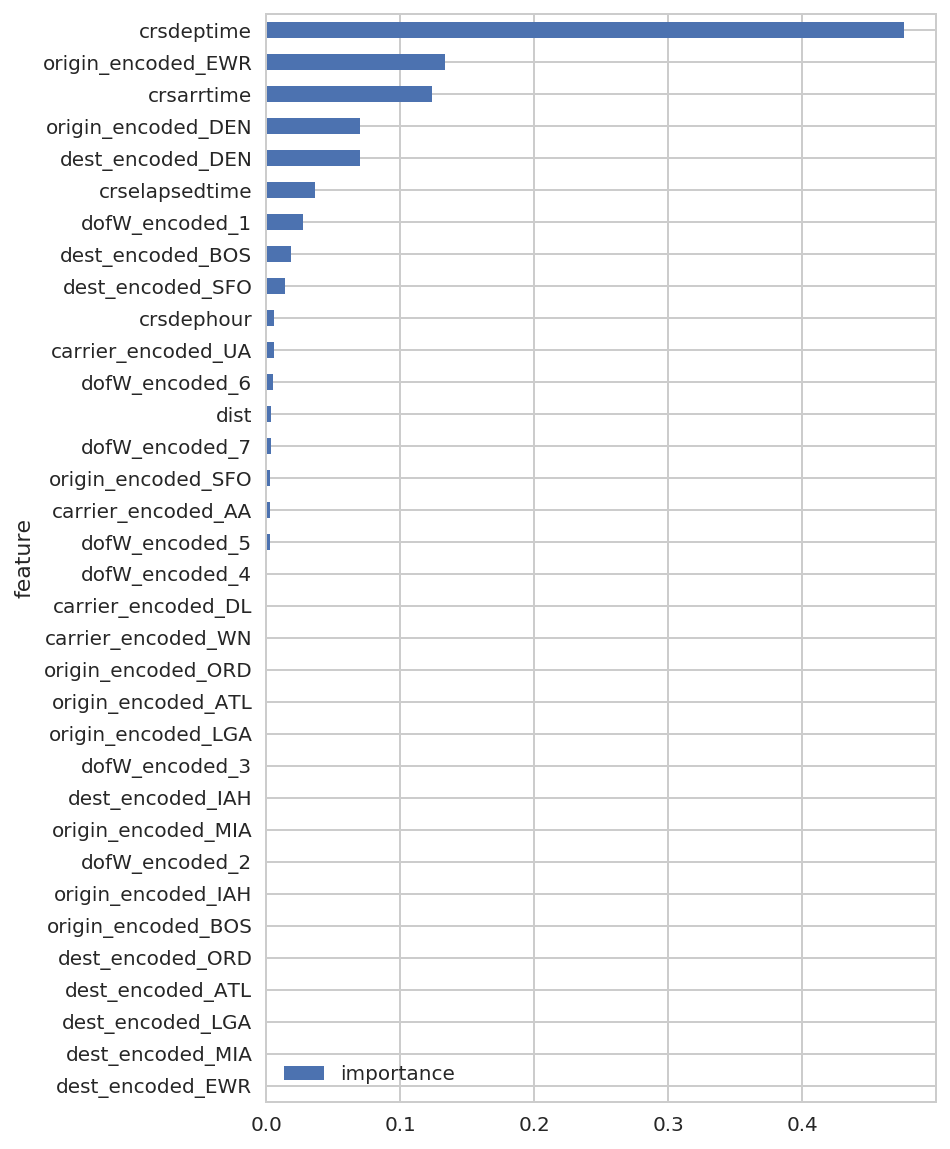

In [149]:
feature_importance_df.sort_values(by='importance', ascending=True).plot.barh(x='feature', figsize=(6, 10));

Decision trees are often used for feature selection because they provide an automated mechanism for determining the most important features (those closest to the tree root).

## 9. Predictions and Model Evaluation

The actual performance of the model can be determined using the test data set that has not been used for any training or cross-validation activities.

We transform the test Dataframe with the model pipeline, which will tranform the features according to the pipeline, estimate and then return the label predictions in a column of a new dataframe.

In [150]:
# transform the test set with the model pipeline,
# which will map the features according to the same recipe
predictions = cvModel.transform(test_df)

### 9.1 Evaluate the predictions accuracy
The evaluator will provide us with the score of the predictions. Accuracy is measured by the area under the ROC curve. The area measures the ability of the test to correctly classify true positives from false positives. A random predictor would have .5 accuracy. The closer the value is to 1 the better its predictions are. In this case, the evaluation returns 81% precision.

In [151]:
accuracy = evaluator.evaluate(predictions)
accuracy

0.8256028868157015

### 9.2 Calculate some more metrics

Below, we calculate some more metrics. The number of false/true positive and negative predictions is also useful:

+ True positives are how often the model correctly predicted delayed flights.
+ False positives are how often the model incorrectly predicted delayed flights.
+ True negatives indicate how often the model correctly predicted not delayed flights.
+ False negatives indicate how often the model incorrectly predicted not delayed flights.

In [152]:
predlbls = predictions.select("prediction", "label")

In [153]:
predlbls.show()

+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  1.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  1.0|
|       0.0|  1.0|
|       0.0|  1.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 20 rows



In [154]:
predlbls.filter(col("label") == 0.0).count(), predlbls.where("label = 0.0").count(), predlbls.filter("label = 0.0").count()

(39665, 39665, 39665)

In [155]:
counttotal = predictions.count()
counttotal

45448

In [156]:
label0count, pred0count = predlbls.filter(col("label") == 0.0).count(), predlbls.filter(col("prediction") == 0.0).count()
label0count, pred0count

(39665, 41473)

In [157]:
label1count, pred1count = predlbls.filter(col("label") == 1.0).count(), predlbls.filter(col("prediction") == 1.0).count()
label1count, pred1count

(5783, 3975)

In [158]:
print("Ground Truth: {0} Not Delayed, {1} Delayed".format(label0count, label1count))

Ground Truth: 39665 Not Delayed, 5783 Delayed


In [159]:
print("Predicted: {0} Not Delayed, {1} Delayed".format(pred0count, pred1count))

Predicted: 41473 Not Delayed, 3975 Delayed


**Null Accuracy:**

In [160]:
# If we would have predicted everything to be Not Delayed then what would have been the accuracy
print("Null Accuracy: ", label0count / counttotal)

Null Accuracy:  0.8727556768174617


In [161]:
correct = predlbls.filter(col('label') == col("prediction")).count()
correct

37522

In [162]:
wrong = predlbls.filter(col('label') != col("prediction")).count()
wrong

7926

In [163]:
ratioWrong = float(wrong)/counttotal
ratioWrong

0.17439711318429854

In [164]:
# We are even doing worse than the Null Accuracy
ratioCorrect = float(correct)/counttotal
print("Accuracy: {0}".format(ratioCorrect))

Accuracy: 0.8256028868157015


> We are even doing worse than the Null Accuracy.

In [165]:
truep = predlbls.filter(col("prediction") == 1.0).filter(col("prediction") == col("label")).count()/ float(counttotal)
print("True Positive: {0}".format(truep))

True Positive: 0.020154902305932053


In [166]:
truen = predlbls.filter(col("prediction") == 0.0).filter(col("prediction") == col("label")).count()/ float(counttotal)
print("True Negative: {0}".format(truen))

True Negative: 0.8054479845097694


In [167]:
falsep = predlbls.filter(col("prediction") == 1.0).filter(col("prediction") != col("label")).count()/ float(counttotal)
print("False Positive: {0}".format(falsep))

False Positive: 0.0673076923076923


In [168]:
falsen = predlbls.filter(col("prediction") == 0.0).filter(col("prediction") != col("label")).count()/ float(counttotal)
print("False Negative: {0}".format(falsen))

False Negative: 0.10708942087660624


In [169]:
precision = truep / (truep + falsep)
print("Precision: {0}".format(precision))

Precision: 0.23044025157232706


In [170]:
recall = truep / (truep + falsen)
print("Recall: {0}".format(recall))

Recall: 0.15839529655887946


In [171]:
f1 = 2 * (precision * recall) / (precision + recall)
print("F1 Score: {0}".format(f1))

F1 Score: 0.18774339003894241


### 9.2 We can calculate similar metrics using `MulticlassMetrics`

In [172]:
metrics = MulticlassMetrics(predlbls.rdd)

In [173]:
metrics.confusionMatrix().toArray()

array([[ 36606.,   3059.],
       [  4867.,    916.]])

In [174]:
f1 = metrics.fMeasure(1.0)
print("F1 Score: {0}".format(f1))

F1 Score: 0.1877433900389424


In [175]:
ratioCorrect = metrics.accuracy
print("Accuracy: {0}".format(ratioCorrect))

Accuracy: 0.8256028868157015


## 10. Save & Load the Model

We can now save our fitted Pipeline for later use with streaming events. This saves both the feature extraction stage and the decision tree model chosen by model tuning.

### 10.1 Save the Model to the file system for later use

In [176]:
type(cvModel.bestModel)

pyspark.ml.pipeline.PipelineModel

In [177]:
MODEL_PATH = 'model/pipeline_model'

In [178]:
cvModel.bestModel.write().overwrite().save(MODEL_PATH)

The result of saving the pipeline model is a JSON file for metadata and a Parquet for model data. We can re-load the model with the load command, the original and re-loaded models are the same:

### 10.2 Reload the Model from the file system for use in a different context

In [179]:
same_cv_model = CrossValidatorModel(bestModel=PipelineModel.load(MODEL_PATH))

In [180]:
same_test_preds = same_cv_model.transform(test_df)

In [181]:
binary_classif_evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")

In [182]:
areaUnderROC = binary_classif_evaluator.evaluate(same_test_preds)
print("areaUnderROC: {0}".format(areaUnderROC))

areaUnderROC: 0.5520688777329082


In [183]:
spark.stop()